# SHAP

## LOAD DATA

In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import umap
from sklearn.neighbors import KDTree
from tqdm import tqdm
import shap

### Load Raw Data

In [2]:
random_seed = 10

def load_all_partitions(directory):
    all_files = glob.glob(os.path.join(directory, '*.csv'))
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

x_raw = load_all_partitions('data/AF-Raw-Data/AF Data/all_raw_data_csv')

# Remove rows that are duplicates or have values > 1800
n_before = x_raw.shape[0]
x_raw = x_raw.drop_duplicates()
x_raw = x_raw[(x_raw.T < 1800).all()]
print(f"Removed {n_before - x_raw.shape[0]} rows with values > 1800 or are duplicate")

# Balance the dataset, by taking the same number of samples from each class
class_1 = x_raw[x_raw['Class_Label'] == 1]
class_0 = x_raw[x_raw['Class_Label'] == 0].sample(len(class_1), random_state=random_seed)
x_raw = pd.concat([class_1, class_0])
print(f"Balanced dataset: {x_raw.shape[0]} samples in total")

x_raw.reset_index(drop=True, inplace=True)
x_raw['Sample_id'] = x_raw.index

# Split the class label from the features and split the data into train and test
y_raw = x_raw[['Class_Label', 'Sample_id']]
x_raw = x_raw.drop(columns=['Class_Label'])
x_raw_train, x_raw_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.2, random_state=random_seed)

Removed 136070 rows with values > 1800 or are duplicate
Balanced dataset: 109272 samples in total


### Create Processed Data

In [3]:
# 30 bins (of 50 milliseconds) are created covering R-R intervals of 200 ms up to 1700 ms. For each
#sample the frequency of an R-R interval occurring in a certain bin was counted.

# Function to bin and count intervals for a row
def bin_row(row, bin_edges):
    intervals = row[:-1].values # Exclude the class label from binning
    bin_indices = np.digitize(intervals, bins=bin_edges, right=False)
    bin_counts = np.bincount(bin_indices, minlength=len(bin_edges)+1)[1:-1]  # Exclude counts outside defined bins
    return bin_counts

bin_edges = np.arange(200, 1751, 50) #ms
bin_column_names = [f'bin_{i + 1}' for i in range(len(bin_edges) - 1)]

def preprocess_into_bins(x_data):
    x_bins = x_data.apply(lambda row: bin_row(row, bin_edges), axis=1, result_type='expand')
    x_bins.columns = bin_column_names
    x_bins['Sample_id'] = x_data['Sample_id']
    return x_bins

x_bins_train = preprocess_into_bins(x_raw_train)
x_bins_test = preprocess_into_bins(x_raw_test)
x_bins = pd.concat([x_bins_train, x_bins_test], ignore_index=True)
x_bins = x_bins.sort_values('Sample_id')

## Train SVM

In [4]:
scaler = StandardScaler()
x_bins_train_scaled = scaler.fit_transform(x_bins_train[bin_column_names])

x_bins_test_scaled = scaler.transform(x_bins_test[bin_column_names])

svm = SVC(random_state=random_seed, kernel='rbf', probability=True)
svm.fit(x_bins_train_scaled, y_train['Class_Label'])

SVC(probability=True, random_state=10)

In [5]:
y_pred_test = svm.predict(x_bins_test_scaled)
y_pred_train = svm.predict(x_bins_train_scaled)

acc_test_svm = accuracy_score(y_test['Class_Label'], y_pred_test)
f1_test_svm = f1_score(y_test['Class_Label'], y_pred_test)

acc_train_svm = accuracy_score(y_train['Class_Label'], y_pred_train)
f1_train_svm = f1_score(y_train['Class_Label'], y_pred_train)

print(f"Test accuracy: {round(acc_test_svm, 4)}, F1: {round(f1_test_svm, 4)}")
print(f"Train accuracy: {round(acc_train_svm, 4)}, F1: {round(f1_train_svm, 4)}")

Test accuracy: 0.9513, F1: 0.9514
Train accuracy: 0.9536, F1: 0.9538


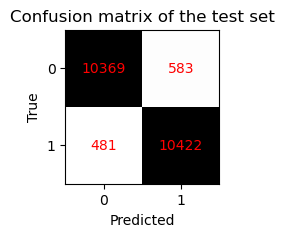

In [6]:
cm_test = confusion_matrix(y_test['Class_Label'], y_pred_test)
#visualise it nicely
plt.figure(figsize=(2, 2))
plt.imshow(cm_test, cmap='binary')
plt.grid(False)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_test[i, j], ha='center', va='center', color='red')
plt.ylabel('True'), plt.xlabel('Predicted'), plt.xticks([0, 1], ['0', '1']), plt.yticks([0, 1], ['0', '1'])
plt.title('Confusion matrix of the test set')
plt.show()

## Random 10% samples

In [7]:
#select random 10000 of the training sample size
num_samples = int(0.1 * x_bins_train_scaled.shape[0])
# num_samples
random_indices = np.random.choice(x_bins_train_scaled.shape[0], num_samples, replace=False)

In [8]:
sub_train_data= x_bins_train_scaled[random_indices]

### Define Shap

In [9]:
f = lambda x: svm.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, sub_train_data)

Using 8741 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [75]:
## Shap function to visualize the importance of each feature

def get_shap_value(record):
    shap_values = explainer.shap_values(record, nsamples=40)
    return shap_values

In [172]:
#visualize the shap values
def vis_SHAP_values(shap_values,record_bin,record_raw,sampleid,type,color_case ='cyan'):
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5),gridspec_kw={'width_ratios': [2,1,1]})
    fig.suptitle(f'Sample: {sampleid}, case: {type}', fontsize=16)
    #plot raw data 
    axs[0].plot(record_raw, color=color_case)
    axs[0].set_title(f"Raw data", fontsize=14)
    axs[0].set_xlabel("Time", fontsize=12)
    axs[0].set_ylabel("R-R interval (ms)", fontsize=12)
    axs[0].set_xticklabels([])
    axs[0].set_ylim(200, 1750)
    
    axs[1].barh(range(0, 31), record_bin,color=color_case)
    axs[1].set_xlabel('Counts',fontsize=12)
    axs[1].set_ylabel('Bins',fontsize=12)
    axs[1].set_title('Histogram of sample', fontsize=14)
    axs[1].set_ylim(0, 31)
    maxval= max(record_bin)
    axs[1].set_xlim(0,maxval+1)
    #plot the FP feature values in horizontal bar chart
    axs[2].barh(range(0, 31), shap_values,color=color_case)
    axs[2].set_xlabel('Shap Value',fontsize=12)
    axs[2].set_ylabel('Bins',fontsize=12)
    axs[2].set_title('Shape values', fontsize=14)
    axs[2].set_ylim(0, 31)
    axs[2].set_xlim(-0.3,0.3)
    plt.savefig("ResultsImg/sample_"+type+sampleid+'.png')
    plt.show()

In [18]:
def vis_shap_forcePlot(shap_values,record,title):
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values, record,feature_names=bin_column_names)
    # plt.savefig("sample_"+title+'.png')
    # plt.show()

## Get all FN,TN,TP,& FP

In [12]:
fp_index_all = []
fn_index_all = []
tp_index_all = []
tn_index_all = []

# fp_found = False
# fn_found = False
# tp_found = False
# tn_found = False

for i in range(len(y_test)):
    actual = y_test['Class_Label'].iloc[i]
    predicted = y_pred_test[i]

    # False Positive (1 predicted, but actually 0)
    if predicted == 1 and actual == 0:
        fp_index_all.append(i) #= i

    # False Negative (0 predicted, but actually 1)
    elif predicted == 0 and actual == 1:
        fn_index_all.append(i) # = i

    # True Positive (1 predicted, actually 1)
    elif predicted == 1 and actual == 1:
        tp_index_all.append(i)# = i

    # True Negative (0 predicted, actually 0)
    elif predicted == 0 and actual == 0:
        tn_index_all.append(i)# = i

    # Break loop if all cases found
    # if fp_found and fn_found and tp_found and tn_found:
    #     break

# Print indices for verification
print("FP Index:", len(fp_index_all))
print("FN Index:", len(fn_index_all))
print("TP Index:", len(tp_index_all))
print("TN Index:", len(tn_index_all))


FP Index: 583
FN Index: 481
TP Index: 10422
TN Index: 10369


## testing 50th sample

In [15]:
shap.initjs()

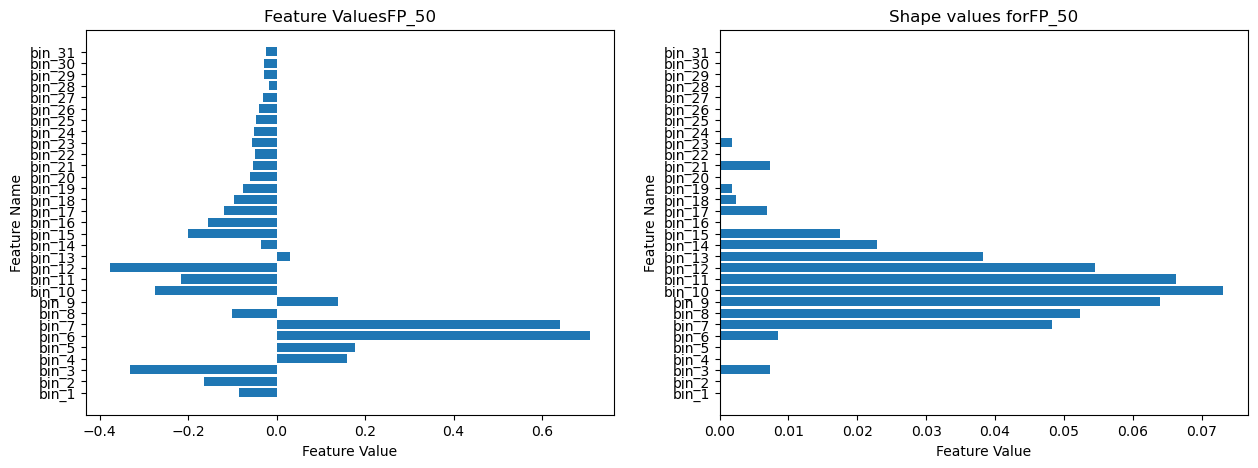

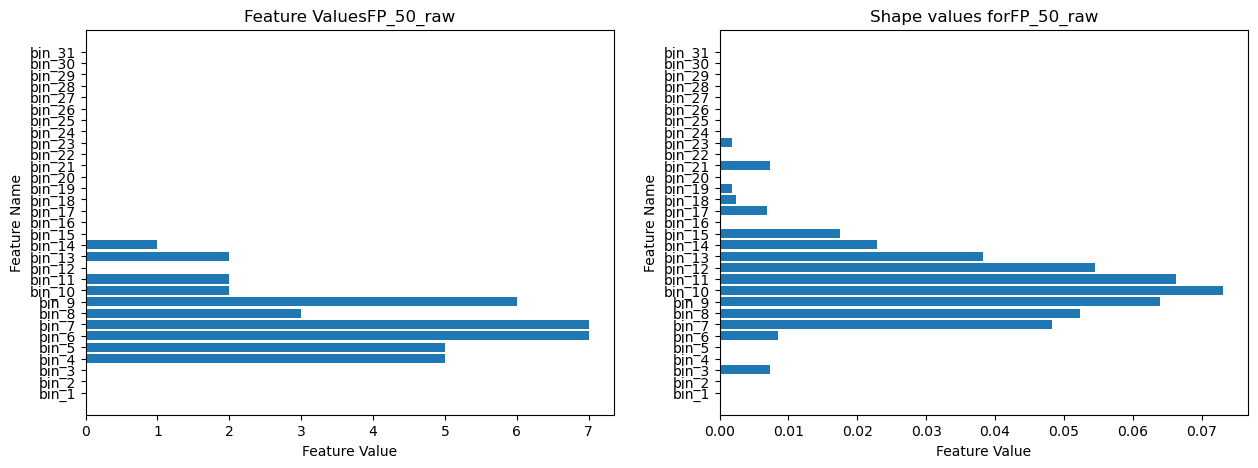

In [21]:
## shap values
#FP record 50
# Normalized data
# shap_values_50 = get_shap_value(fp_index_all[50])

record_50 = x_bins_test_scaled[fp_index_all[50]]
vis_SHAP_values(shap_values_50,record_50,"FP_50")

## raw data
fp_test_50=x_bins_test.iloc[fp_index_all[50]]
fp_test_50=fp_test_50[bin_column_names]
vis_SHAP_values(shap_values_50,fp_test_50,"FP_50_raw")

In [22]:
shap.force_plot(explainer.expected_value, shap_values_50, record_50,feature_names=bin_column_names)

In [23]:
shap.force_plot(explainer.expected_value, shap_values_50, fp_test_50,feature_names=bin_column_names)

In [35]:
x_bins_test['Prediction'] = y_pred_test
x_bins_train['Prediction'] = y_pred_train
x_bins_test['Class_Label'] = y_test['Class_Label']
x_bins_train['Class_Label'] = y_train['Class_Label']

def add_col_cm_label(x_df):
    # Add a column indicating TP, TN, FP, FN, name the column 'CM_Label'
    x_df['CM_Label'] = ''
    x_df.loc[(x_df['Prediction'] == 1) & (x_df['Class_Label'] == 1), 'CM_Label'] = 'TP'
    x_df.loc[(x_df['Prediction'] == 0) & (x_df['Class_Label'] == 0), 'CM_Label'] = 'TN'
    x_df.loc[(x_df['Prediction'] == 1) & (x_df['Class_Label'] == 0), 'CM_Label'] = 'FP'
    x_df.loc[(x_df['Prediction'] == 0) & (x_df['Class_Label'] == 1), 'CM_Label'] = 'FN'
    return x_df

x_bins_test = add_col_cm_label(x_bins_test)
x_bins_train = add_col_cm_label(x_bins_train)

In [43]:
#reset index in test 
x_bins_test_reset = x_bins_test.reset_index(drop=True)

In [57]:
# Plot a sample

def plot_sample(index, color_case ='cyan'):

    sample_bin = x_bins_test_reset.iloc[index]
    # print(sample_bin['Sample_id'])
    sample_pred = sample_bin['Prediction']
    sample_gt = sample_bin['Class_Label']
    sample_cm_label = sample_bin['CM_Label']
    sample_raw = x_raw_test[sample_bin['Sample_id'] == x_raw_test['Sample_id']].iloc[0]

    fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [2, 1]})
    # fig.suptitle(f'Sample: {sample_id}, case: {sample_cm_label}', fontsize=16)

    # Plot the raw data
    axs[0].plot(sample_raw, color=color_case)
    axs[0].set_title(f"Raw data", fontsize=14)
    axs[0].set_xlabel("Time", fontsize=12)
    axs[0].set_ylabel("R-R interval (ms)", fontsize=12)
    axs[0].set_xticklabels([])
    axs[0].set_ylim(200, 1750)

    axs[1].barh(range(0, 31), sample_bin[bin_column_names], color=color_case)
    axs[1].set_title(f"Histogram of sample", fontsize=14)
    axs[1].set_xlabel("Count", fontsize=12)
    axs[1].set_ylabel("Bin", fontsize=12)
    axs[1].set_ylim(0, 30)

    plt.tight_layout()
    plt.show()

# plot_sample(19796)



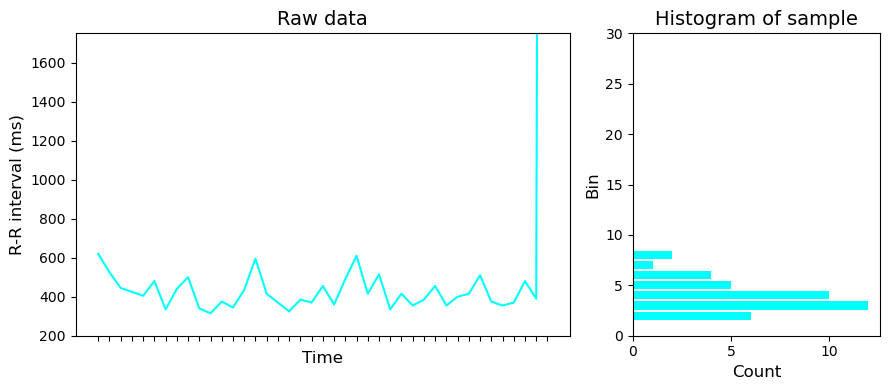

In [58]:
#plot 50th index in plot sample
plot_sample(0)

In [25]:
#randomly select 10 samples from each class
#FP
fp_index_10 = np.random.choice(fp_index_all, 10, replace=False)
#FN
fn_index_10 = np.random.choice(fn_index_all, 10, replace=False)
#TP
tp_index_10 = np.random.choice(tp_index_all, 10, replace=False)
#TN
tn_index_10 = np.random.choice(tn_index_all, 10, replace=False)

# TP

In [110]:
# #plot all 10 FP samples with shap values and force plot
# shap_values_tp = []
# for i in range(4):
#     record = x_bins_test_scaled[tp_index_10[i]]
#     shap_val = get_shap_value(record)
#     shap_values_tp.append(shap_val)
#     vis_SHAP_values(shap_val,record,"TP_"+str(tp_index_10[i]))
#     tp_test=x_bins_test.iloc[tp_index_10[i]]
#     tp_test=tp_test[bin_column_names]
#     vis_SHAP_values(shap_val,tp_test,"TP_"+str(tp_index_10[i])+"_raw")
#     vis_shap_forcePlot(shap_val,record,"TP_force_"+str(tp_index_10[i]))

In [111]:
# #plot all 4 TP samples
# for i in tp_index_10:
#     plot_sample(i, color_case='green')

# FN

In [112]:
# #plot all 10 FN samples with shap values and force plot
# shap_values_fn = np.zeros((4, 30))
# 
# for i in range(4):
#     record = x_bins_test_scaled[fn_index_10[i]]
#     shap_val = get_shap_value(record)
#     shap_values_fn[i] = shap_val
#     vis_SHAP_values(shap_val,record,"FN_"+str(fn_index_10[i]))
#     fn_test=x_bins_test.iloc[fn_index_10[i]]
#     fn_test=fn_test[bin_column_names]
#     vis_SHAP_values(shap_val,fn_test,"FN_"+str(fn_index_10[i])+"_raw")
#     vis_shap_forcePlot(shap_val,record,"FN_force_"+str(fn_index_10[i]))

In [113]:
# #plot all 4 FN samples
# for i in fn_index_10[:4]:
#     plot_sample(i, color_case='red')

# TN

In [115]:
# #plot all 10 TN samples with shap values and force plot
# shap_values_tn = np.zeros((4, 30))
# 
# for i in range(4):
#     record = x_bins_test_scaled[tn_index_10[i]]
#     shap_val = get_shap_value(record)
#     shap_values_tn[i] = shap_val
#     vis_SHAP_values(shap_val,record,"TN_"+str(tn_index_10[i]))
#     tn_test=x_bins_test.iloc[tn_index_10[i]]
#     tn_test=tn_test[bin_column_names]
#     vis_SHAP_values(shap_val,tn_test,"TN_"+str(tn_index_10[i])+"_raw")
#     vis_shap_forcePlot(shap_val,record,"TN_force_"+str(tn_index_10[i]))

In [120]:
# #plot all 4 TN samples
# for i in tn_index_10[:4]:
#     plot_sample(i, color_case='blue')

## Analysing GIJS's data

In [67]:
## load file names from path
def load_files_from_path(path):
    all_files = glob.glob(os.path.join(path, '*.csv'))
    return all_files

In [70]:
clusterDataFiles = load_files_from_path('samples')

In [71]:
clusterDataFiles

['samples/tn_sample_top_bin_scaled.csv',
 'samples/fn_sample_db_bin_scaled.csv',
 'samples/tp_sample_db_bin_scaled.csv',
 'samples/fp_sample_db_bin.csv',
 'samples/fn_sample_db_bin.csv',
 'samples/tn_sample_top_bin.csv',
 'samples/fn_sample_top_bin.csv',
 'samples/fp_sample_rightmiddle_raw.csv',
 'samples/tp_sample_rightmiddle_raw.csv',
 'samples/fp_sample_rightmiddle_bin_scaled.csv',
 'samples/tn_sample_db_bin.csv',
 'samples/tp_sample_db_bin.csv',
 'samples/tp_sample_db_raw.csv',
 'samples/tn_sample_db_raw.csv',
 'samples/tn_sample_top_raw.csv',
 'samples/tp_sample_rightmiddle_bin.csv',
 'samples/fp_sample_rightmiddle_bin.csv',
 'samples/fn_sample_top_raw.csv',
 'samples/fn_sample_db_raw.csv',
 'samples/tp_sample_rightmiddle_bin_scaled.csv',
 'samples/fp_sample_db_raw.csv',
 'samples/fp_sample_db_bin_scaled.csv',
 'samples/tn_sample_db_bin_scaled.csv',
 'samples/fn_sample_top_bin_scaled.csv']

In [85]:
record1 = pd.read_csv(db_files[0])
shap_values = get_shap_value(record1.iloc[0])

In [84]:
record1.iloc[0]

bin_1     12.972204
bin_2      0.472766
bin_3     -0.330696
bin_4     -0.520942
bin_5     -0.695599
bin_6     -0.260358
bin_7      1.941251
bin_8      0.503369
bin_9     -0.284890
bin_10    -0.163020
bin_11    -0.331768
bin_12    -0.242603
bin_13    -0.135769
bin_14    -0.248948
bin_15     0.344800
bin_16    -0.154807
bin_17    -0.120069
bin_18    -0.096912
bin_19    -0.073007
bin_20    -0.063721
bin_21    -0.053325
bin_22    -0.052613
bin_23    -0.054403
bin_24    -0.054692
bin_25    -0.043127
bin_26    -0.032260
bin_27    -0.017466
bin_28    -0.029817
bin_29    -0.024109
bin_30    -0.028728
bin_31    -0.021912
Name: 0, dtype: float64

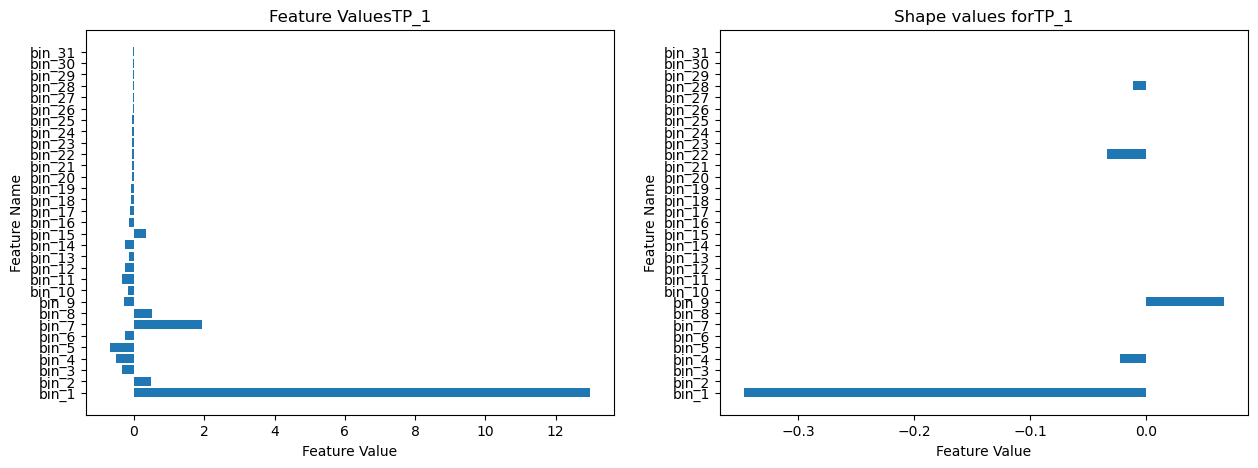

In [86]:
vis_SHAP_values(shap_values,record1.iloc[0],"TP_"+str(1))

   bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  bin_8  bin_9  bin_10  ...  \
0      4      1      0      0      0      2     15      8      2       3  ...   

   bin_28  bin_29  bin_30  bin_31  Sample_id  Prediction  Class_Label  \
0       0       0       0       0      14719         0.0          1.0   

   CM_Label    UMAP_1    UMAP_2  
0        FN -2.685063 -0.145056  

[1 rows x 37 columns]


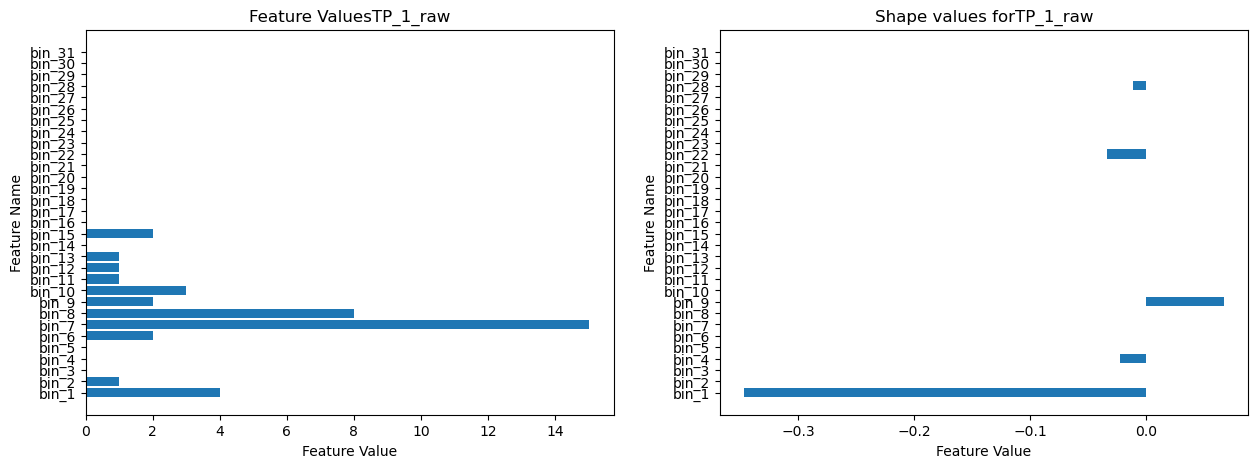

In [97]:
record1_raw = pd.read_csv('samples/fn_sample_db_bin.csv')
print(record1_raw)
record1_raw=record1_raw[bin_column_names].iloc[0]
vis_SHAP_values(shap_values,record1_raw,"TP_"+str(1)+"_raw")

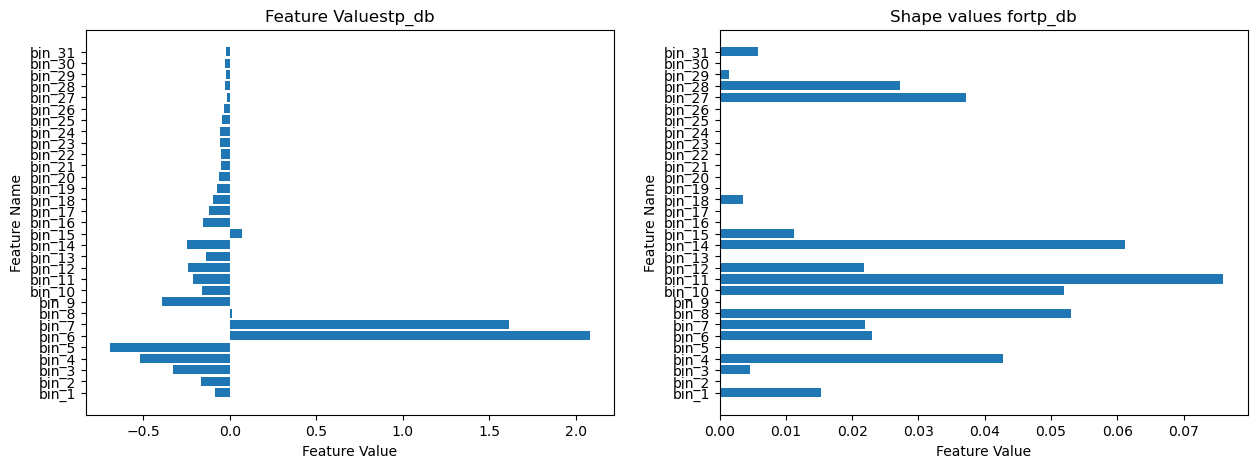

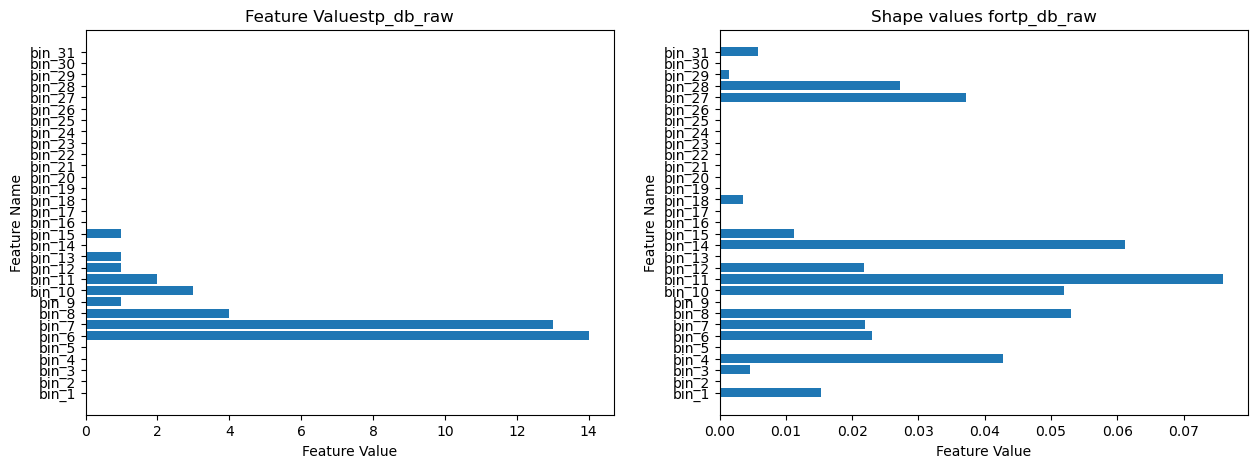

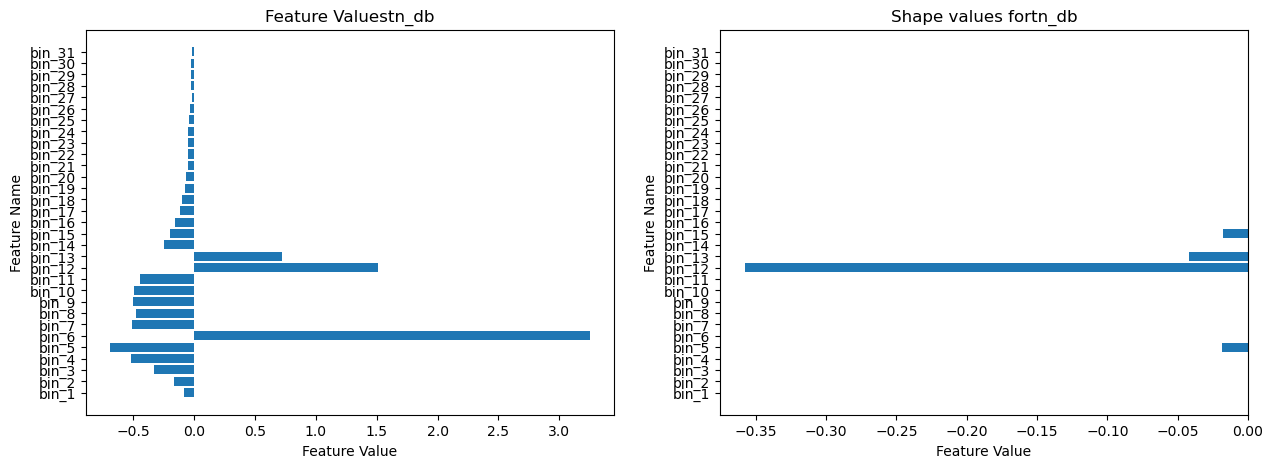

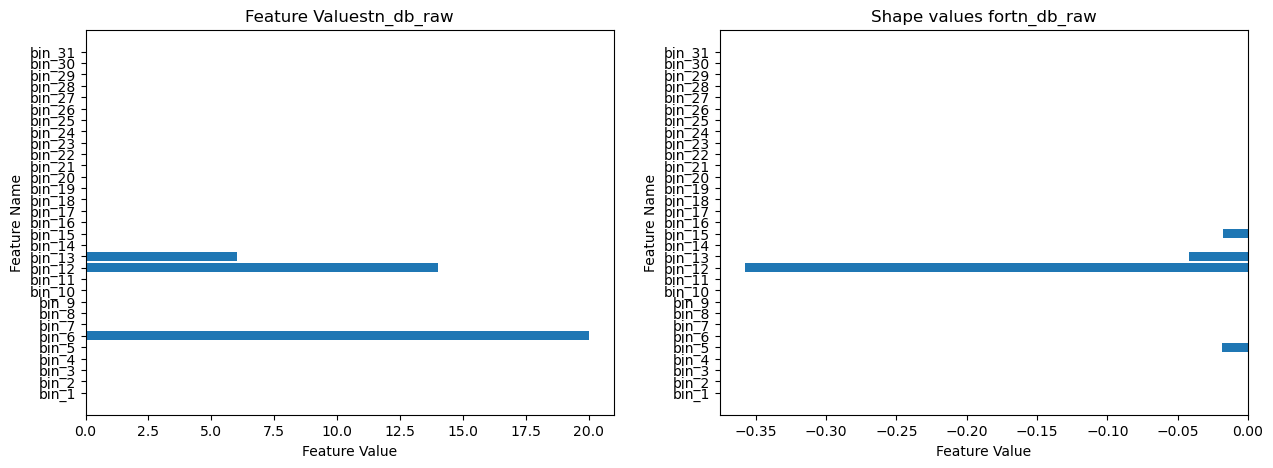

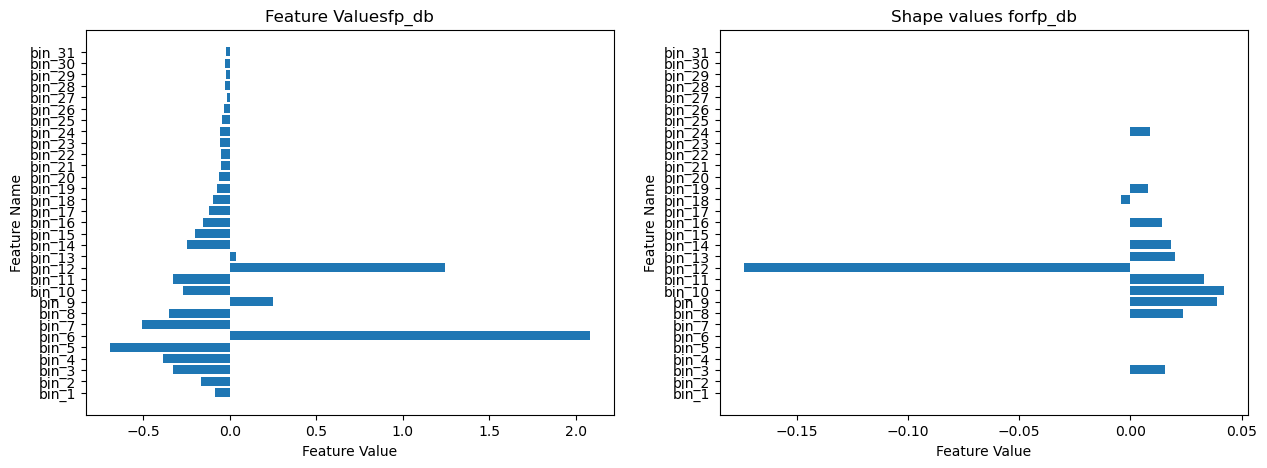

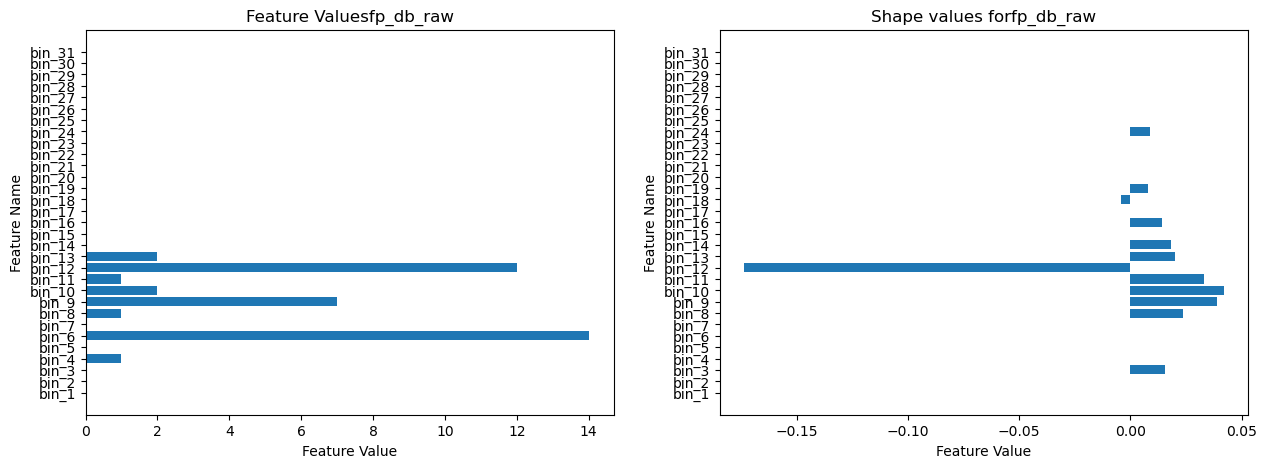

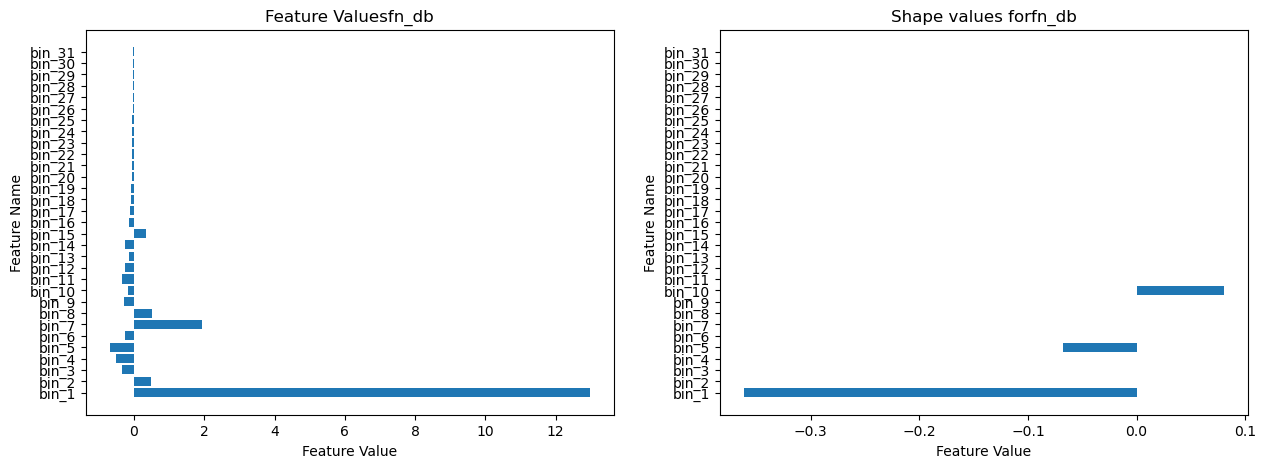

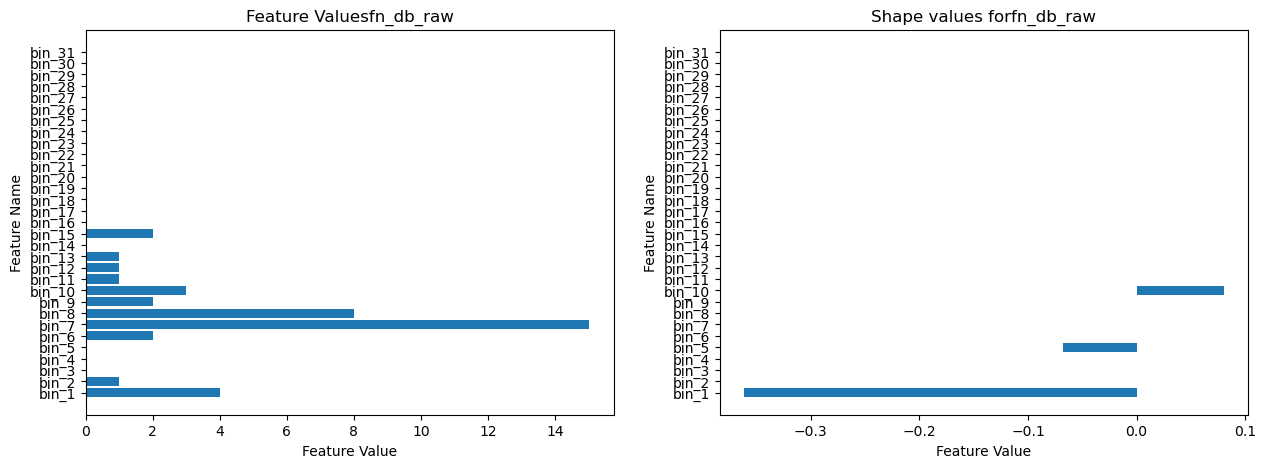

In [99]:
shap_values_db = np.zeros((4, 30))
# for files in db_files:
for i in ['tp','tn','fp','fn']:
    file_scared = 'samples/'+ i + '_sample_db_bin_scaled.csv'
    data= pd.read_csv(file_scared).iloc[0]
    file_raw = 'samples/'+ i + '_sample_db_bin.csv'
    data_raw= pd.read_csv(file_raw)
    shap_val = get_shap_value(data)
    # shap_values_db[i]= shap_val
    data_raw=data_raw[bin_column_names].iloc[0]
    # print(data_raw)
    vis_SHAP_values(shap_val,data,str(i)+ "_db")
    vis_SHAP_values(shap_val,data_raw,str(i)+ "_db" +"_raw")
    vis_shap_forcePlot(shap_val,data,str(i)+ "_db")

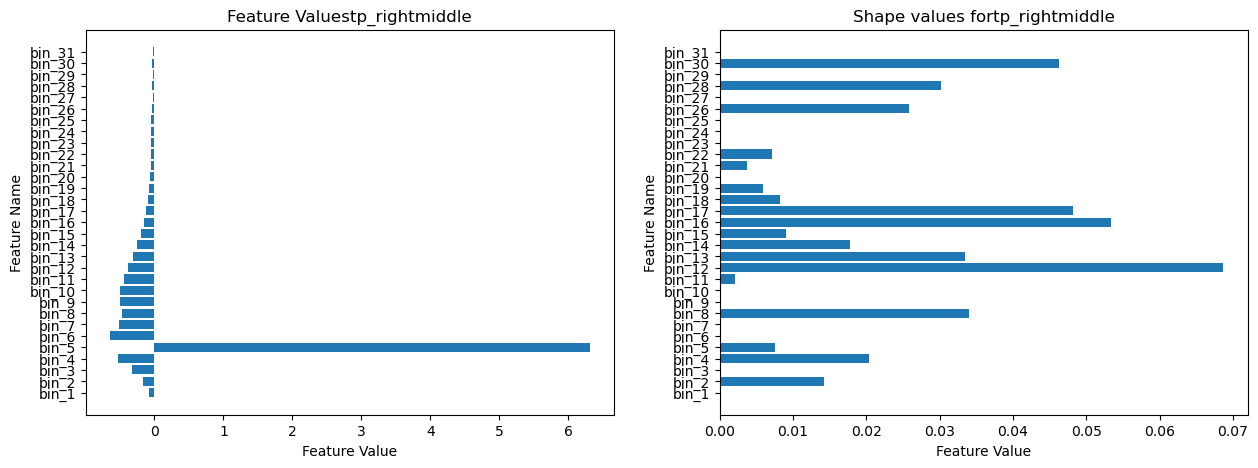

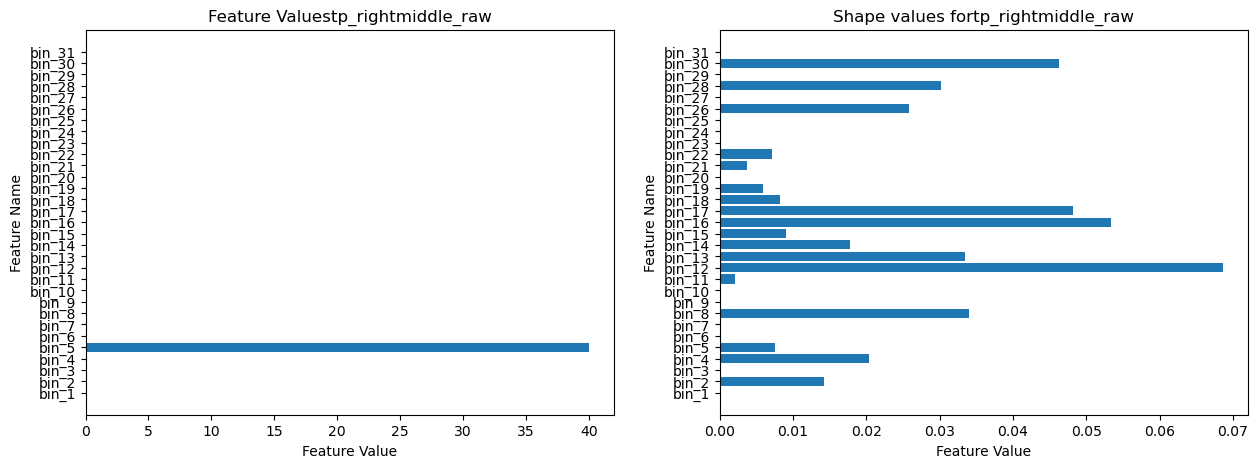

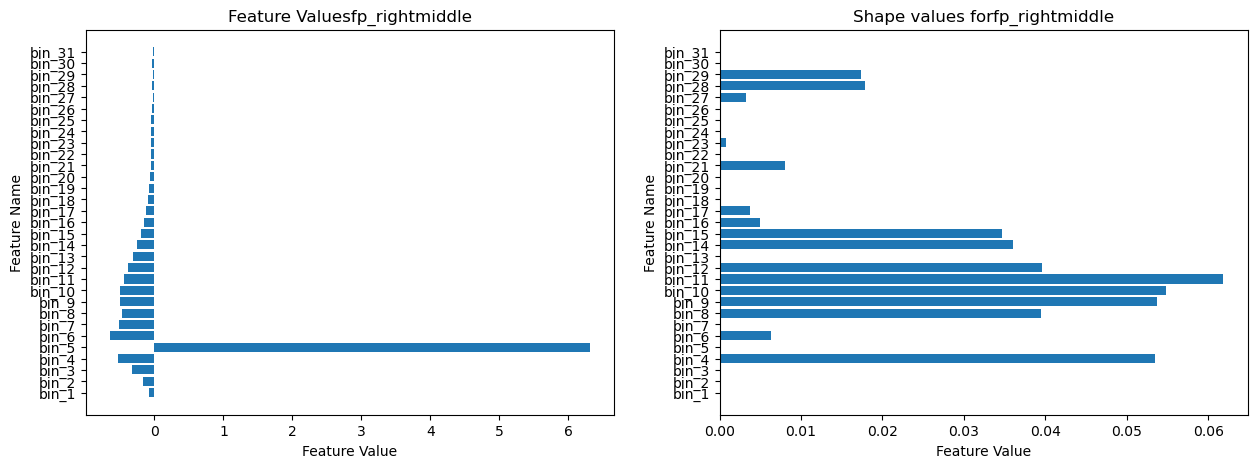

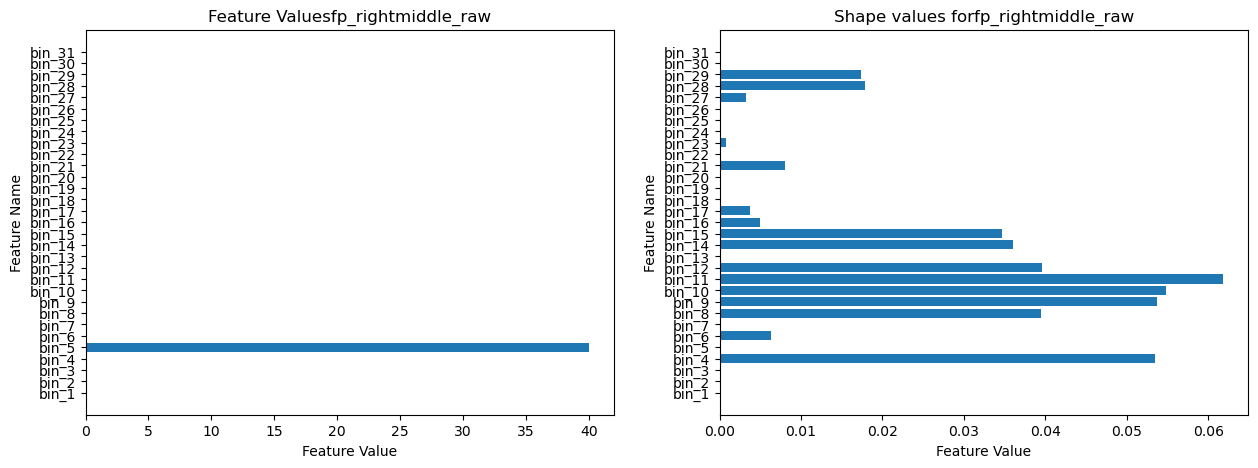

FileNotFoundError: [Errno 2] No such file or directory: 'samples/tn_sample_rightmiddle_bin_scaled.csv'

In [101]:
shap_values_db = np.zeros((4, 30))
# for files in db_files:
for i in ['tp','fp']:
    file_scared = 'samples/'+ i + '_sample_rightmiddle_bin_scaled.csv'
    data= pd.read_csv(file_scared).iloc[0]
    file_raw = 'samples/'+ i + '_sample_rightmiddle_bin.csv'
    data_raw= pd.read_csv(file_raw)
    shap_val = get_shap_value(data)
    # shap_values_db[i]= shap_val
    data_raw=data_raw[bin_column_names].iloc[0]
    # print(data_raw)
    vis_SHAP_values(shap_val,data,str(i)+ "_rightmiddle")
    vis_SHAP_values(shap_val,data_raw,str(i)+ "_rightmiddle" +"_raw")
    vis_shap_forcePlot(shap_val,data,str(i)+ "_rightmiddle")

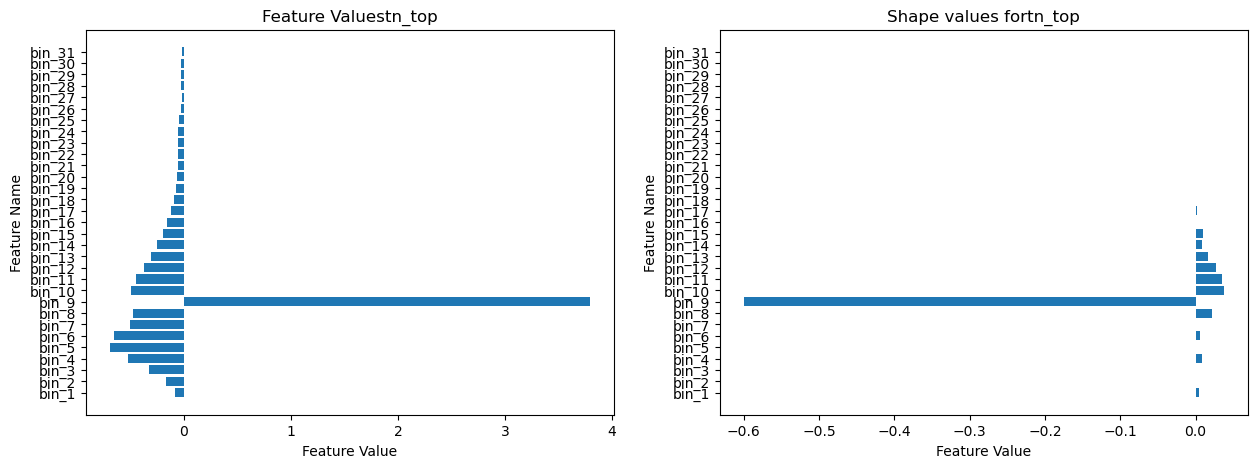

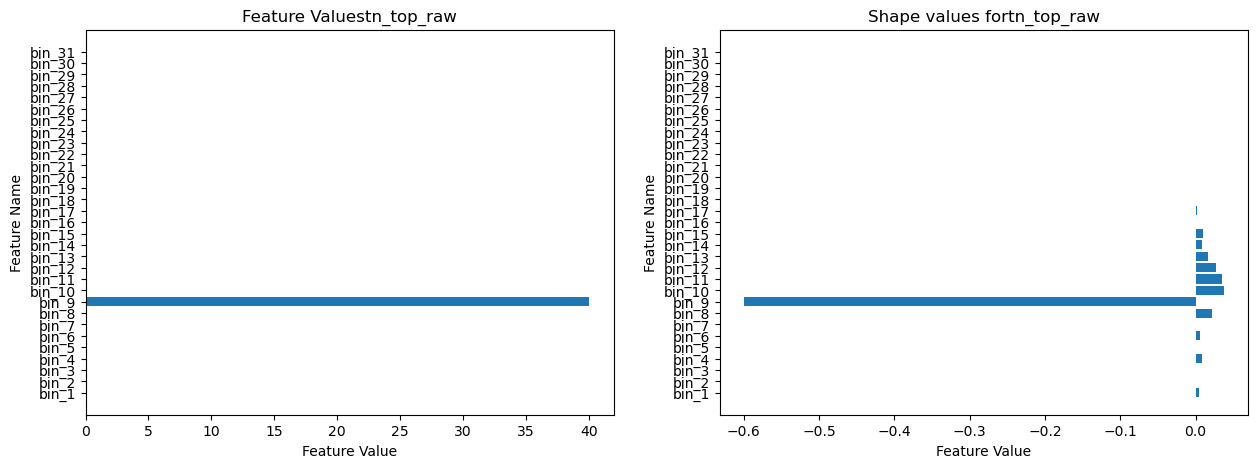

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:679: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=9.242e-06, previous alpha=7.810e-06, with an active set of 19 regressors.
  warnings.warn(


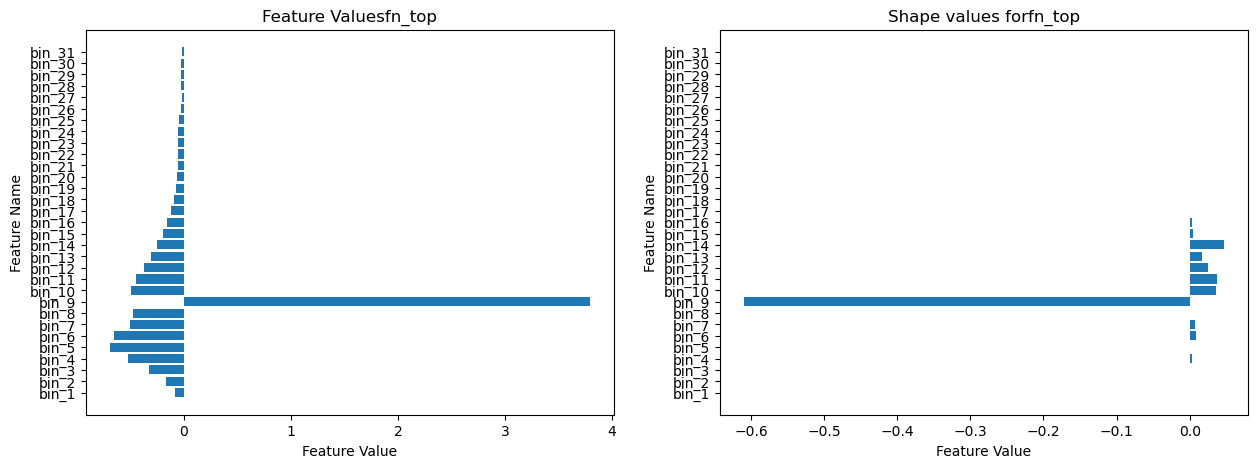

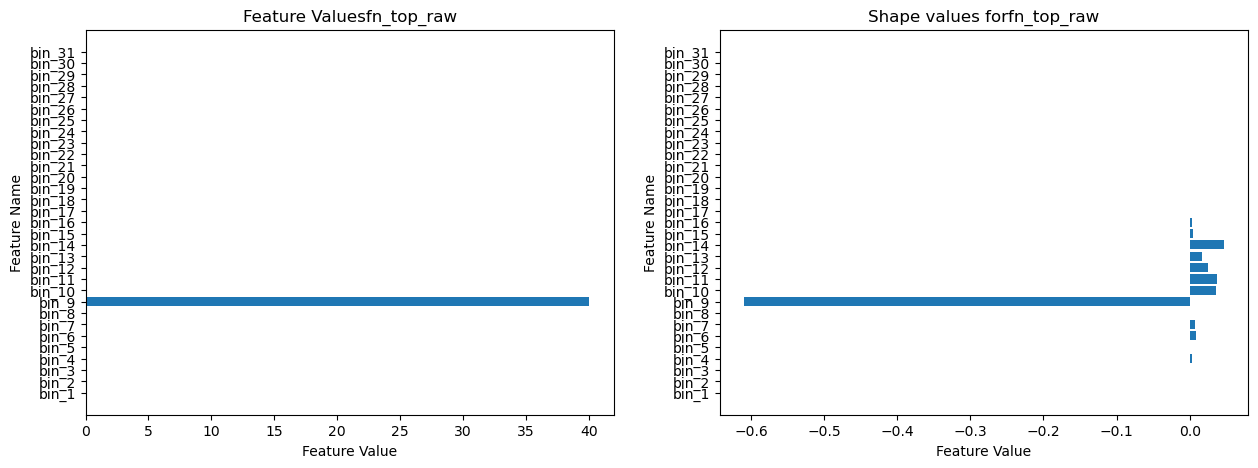

In [102]:
shap_values_db = np.zeros((4, 30))
# for files in db_files:
for i in ['tn','fn']:
    file_scared = 'samples/'+ i + '_sample_top_bin_scaled.csv'
    data= pd.read_csv(file_scared).iloc[0]
    file_raw = 'samples/'+ i + '_sample_top_bin.csv'
    data_raw= pd.read_csv(file_raw)
    shap_val = get_shap_value(data)
    # shap_values_db[i]= shap_val
    data_raw=data_raw[bin_column_names].iloc[0]
    # print(data_raw)
    vis_SHAP_values(shap_val,data,str(i)+ "_top")
    vis_SHAP_values(shap_val,data_raw,str(i)+ "_top" +"_raw")
    vis_shap_forcePlot(shap_val,data,str(i)+ "_top")

In [103]:
file_scared = 'samples/fn_sample_top_bin_scaled.csv'
data= pd.read_csv(file_scared).iloc[0]
file_raw = 'samples/fn_sample_top_bin.csv'
data_raw= pd.read_csv(file_raw)
data_raw=data_raw[bin_column_names].iloc[0]

In [104]:
print(data)
print(data_raw)

bin_1    -0.084351
bin_2    -0.164330
bin_3    -0.330696
bin_4    -0.520942
bin_5    -0.695599
bin_6    -0.650521
bin_7    -0.508377
bin_8    -0.476258
bin_9     3.793508
bin_10   -0.493286
bin_11   -0.447944
bin_12   -0.377444
bin_13   -0.306417
bin_14   -0.248948
bin_15   -0.199351
bin_16   -0.154807
bin_17   -0.120069
bin_18   -0.096912
bin_19   -0.073007
bin_20   -0.063721
bin_21   -0.053325
bin_22   -0.052613
bin_23   -0.054403
bin_24   -0.054692
bin_25   -0.043127
bin_26   -0.032260
bin_27   -0.017466
bin_28   -0.029817
bin_29   -0.024109
bin_30   -0.028728
bin_31   -0.021912
Name: 0, dtype: float64
bin_1      0
bin_2      0
bin_3      0
bin_4      0
bin_5      0
bin_6      0
bin_7      0
bin_8      0
bin_9     40
bin_10     0
bin_11     0
bin_12     0
bin_13     0
bin_14     0
bin_15     0
bin_16     0
bin_17     0
bin_18     0
bin_19     0
bin_20     0
bin_21     0
bin_22     0
bin_23     0
bin_24     0
bin_25     0
bin_26     0
bin_27     0
bin_28     0
bin_29     0
bin_30    

In [107]:
file_scared = 'samples/tn_sample_top_bin_scaled.csv'
data= pd.read_csv(file_scared).iloc[0]
file_raw = 'samples/tn_sample_top_bin.csv'
data_raw= pd.read_csv(file_raw)
data_raw=data_raw[bin_column_names].iloc[0]

In [108]:
data_raw

bin_1      0
bin_2      0
bin_3      0
bin_4      0
bin_5      0
bin_6      0
bin_7      0
bin_8      0
bin_9     40
bin_10     0
bin_11     0
bin_12     0
bin_13     0
bin_14     0
bin_15     0
bin_16     0
bin_17     0
bin_18     0
bin_19     0
bin_20     0
bin_21     0
bin_22     0
bin_23     0
bin_24     0
bin_25     0
bin_26     0
bin_27     0
bin_28     0
bin_29     0
bin_30     0
bin_31     0
Name: 0, dtype: int64

In [157]:
## DP FP

file_scaled = 'samples/fp_sample_db_bin_scaled.csv'
file_raw = 'samples/fp_sample_db_raw.csv'
file_bin = 'samples/fp_sample_db_bin.csv'

data= pd.read_csv(file_scaled).iloc[0]
data_raw= pd.read_csv(file_raw)
sampleID= data_raw['Sample_id'].iloc[0]
data_raw=data_raw.iloc[0][:-1]
data_bin = pd.read_csv(file_bin)
data_bin = data_bin[bin_column_names].iloc[0]
shap_val = get_shap_value(data)

# shap_values,record_bin,record_raw,sampleid,type,color_case ='cyan'

In [160]:
pd.read_csv(file_raw)

s_0  s_1  s_2  s_3  s_4  s_5  s_6  s_7  s_8  s_9  ...  s_31  s_32  s_33  \
0  750  465  765  460  765  460  755  470  750  470  ...   620   800   630   

   s_34  s_35  s_36  s_37  s_38  s_39  Sample_id  
0   635   630   640   470   800   395      99158  

[1 rows x 41 columns]

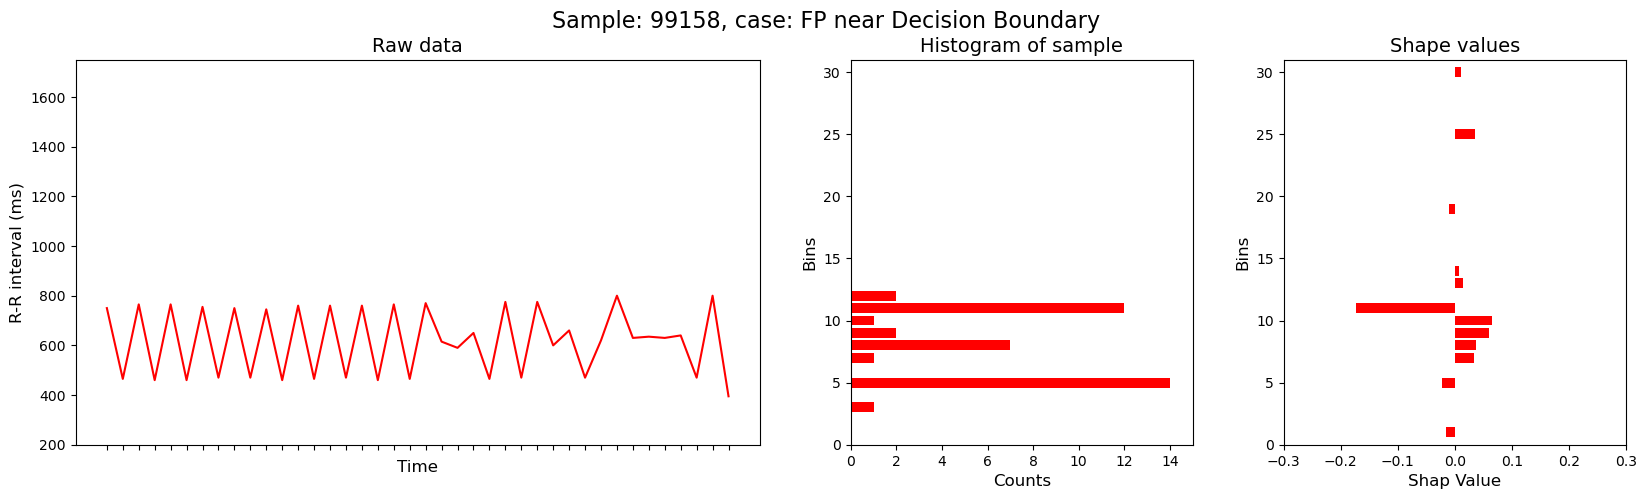

In [158]:
vis_SHAP_values(shap_val,data_bin,data_raw,str(sampleID), "FP near Decision Boundary",color_case='red')

In [163]:
## DP FP

file_scaled = 'samples/tp_sample_db_bin_scaled.csv'
file_raw = 'samples/tp_sample_db_raw.csv'
file_bin = 'samples/tp_sample_db_bin.csv'

data_tp= pd.read_csv(file_scaled).iloc[0]
data_raw_tp= pd.read_csv(file_raw)
sampleID_tp= data_raw_tp['Sample_id'].iloc[0]
print(pd.read_csv(file_raw))
data_raw_tp=data_raw_tp.iloc[0][:-1]
data_bin_tp = pd.read_csv(file_bin)
data_bin_tp = data_bin_tp[bin_column_names].iloc[0]
# shap_val_tp = get_shap_value(data_tp)

# shap_values,record_bin,record_raw,sampleid,type,color_case ='cyan'

   s_0  s_1  s_2  s_3  s_4  s_5  s_6  s_7  s_8  s_9  ...  s_31  s_32  s_33  \
0  520  520  470  455  495  455  520  530  505  475  ...   670   495   485   

   s_34  s_35  s_36  s_37  s_38  s_39  Sample_id  
0   800   540   485   575   530   465      14257  

[1 rows x 41 columns]


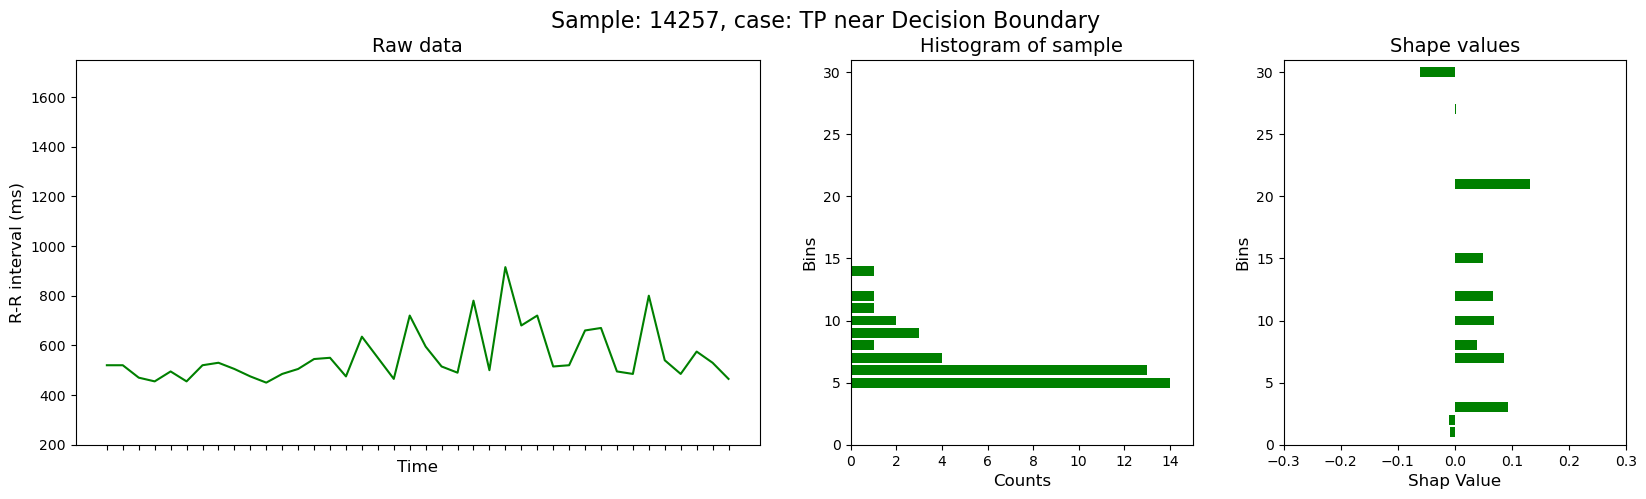

In [164]:
vis_SHAP_values(shap_val_tp,data_bin_tp,data_raw_tp,str(sampleID_tp), "TP near Decision Boundary",color_case='green')

In [165]:
#plot the db fn
file_scaled = 'samples/fn_sample_db_bin_scaled.csv'
file_raw = 'samples/fn_sample_db_raw.csv'
file_bin = 'samples/fn_sample_db_bin.csv'

data_fn= pd.read_csv(file_scaled).iloc[0]
data_raw_fn= pd.read_csv(file_raw)
sampleID_fn= data_raw_fn['Sample_id'].iloc[0]
data_raw_fn=data_raw_fn.iloc[0][:-1]
data_bin_fn = pd.read_csv(file_bin)
data_bin_fn = data_bin_fn[bin_column_names].iloc[0]
shap_val_fn = get_shap_value(data_fn)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.836e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.113e-05, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:679: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=3.939e-05, previous alpha=2.30

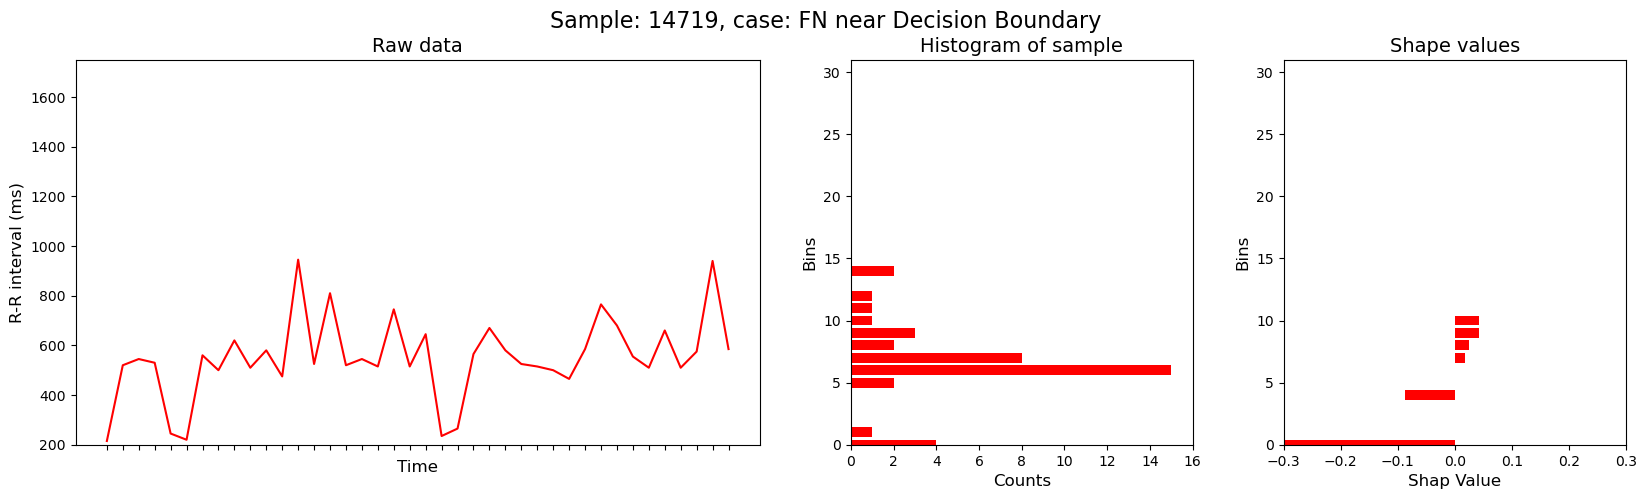

In [173]:
vis_SHAP_values(shap_val_fn,data_bin_fn,data_raw_fn,str(sampleID_fn), "FN near Decision Boundary",color_case='red')

In [167]:
#plot the db tn
file_scaled = 'samples/tn_sample_db_bin_scaled.csv'
file_raw = 'samples/tn_sample_db_raw.csv'
file_bin = 'samples/tn_sample_db_bin.csv'

data_tn= pd.read_csv(file_scaled).iloc[0]
data_raw_tn= pd.read_csv(file_raw)
sampleID_tn= data_raw_tn['Sample_id'].iloc[0]
data_raw_tn=data_raw_tn.iloc[0][:-1]
data_bin_tn = pd.read_csv(file_bin)
data_bin_tn = data_bin_tn[bin_column_names].iloc[0]
shap_val_tn = get_shap_value(data_tn)

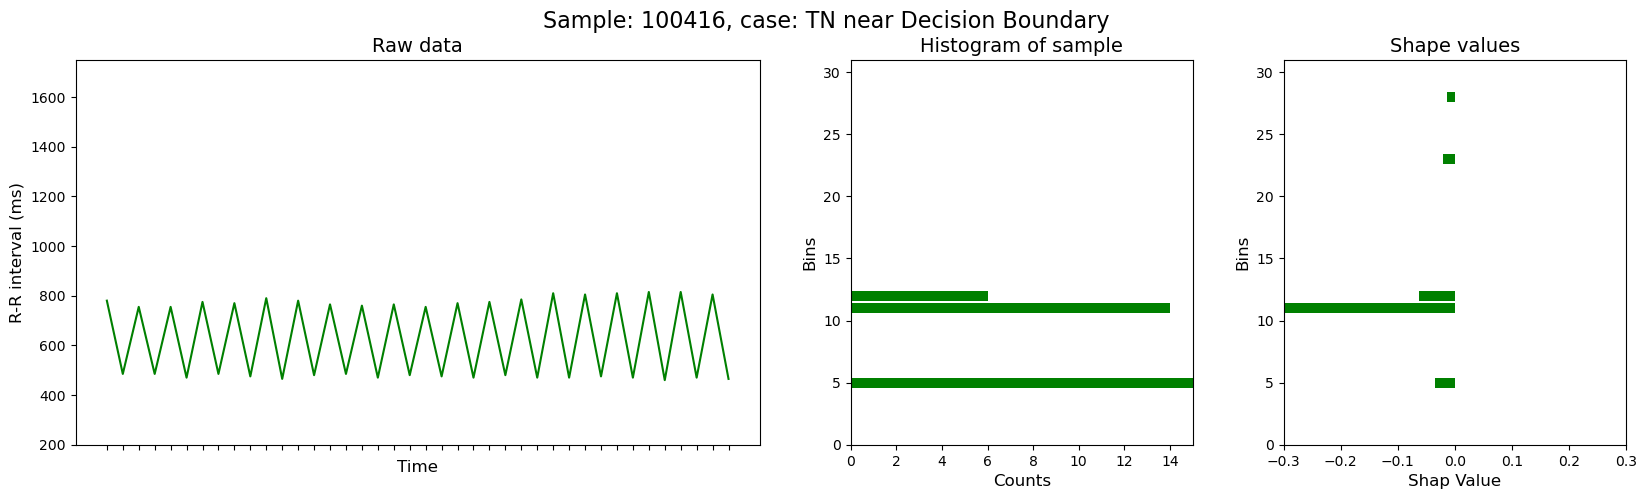

In [170]:
vis_SHAP_values(shap_val_tn,data_bin_tn,data_raw_tn,str(sampleID_tn), "TN near Decision Boundary",color_case='green')

In [177]:
# Plot top tn
file_scaled = 'samples/tn_sample_top_bin_scaled.csv'
file_raw = 'samples/tn_sample_top_raw.csv'
file_bin = 'samples/tn_sample_top_bin.csv'

data_top_tn= pd.read_csv(file_scaled).iloc[0]
data_raw_top_tn= pd.read_csv(file_raw)
sampleID_top_tn= data_raw_top_tn['Sample_id'].iloc[0]
data_raw_top_tn=data_raw_top_tn.iloc[0][:-1]
data_bin_top_tn = pd.read_csv(file_bin)
data_bin_top_tn = data_bin_top_tn[bin_column_names].iloc[0]
shap_val_top_tn = get_shap_value(data_top_tn)

In [178]:
data_raw_top_tn

s_0     610
s_1     620
s_2     620
s_3     610
s_4     620
s_5     615
s_6     610
s_7     620
s_8     615
s_9     615
s_10    615
s_11    615
s_12    615
s_13    605
s_14    615
s_15    620
s_16    625
s_17    615
s_18    615
s_19    620
s_20    620
s_21    620
s_22    615
s_23    630
s_24    625
s_25    615
s_26    625
s_27    620
s_28    615
s_29    630
s_30    625
s_31    625
s_32    625
s_33    630
s_34    630
s_35    635
s_36    630
s_37    630
s_38    635
s_39    635
Name: 0, dtype: int64

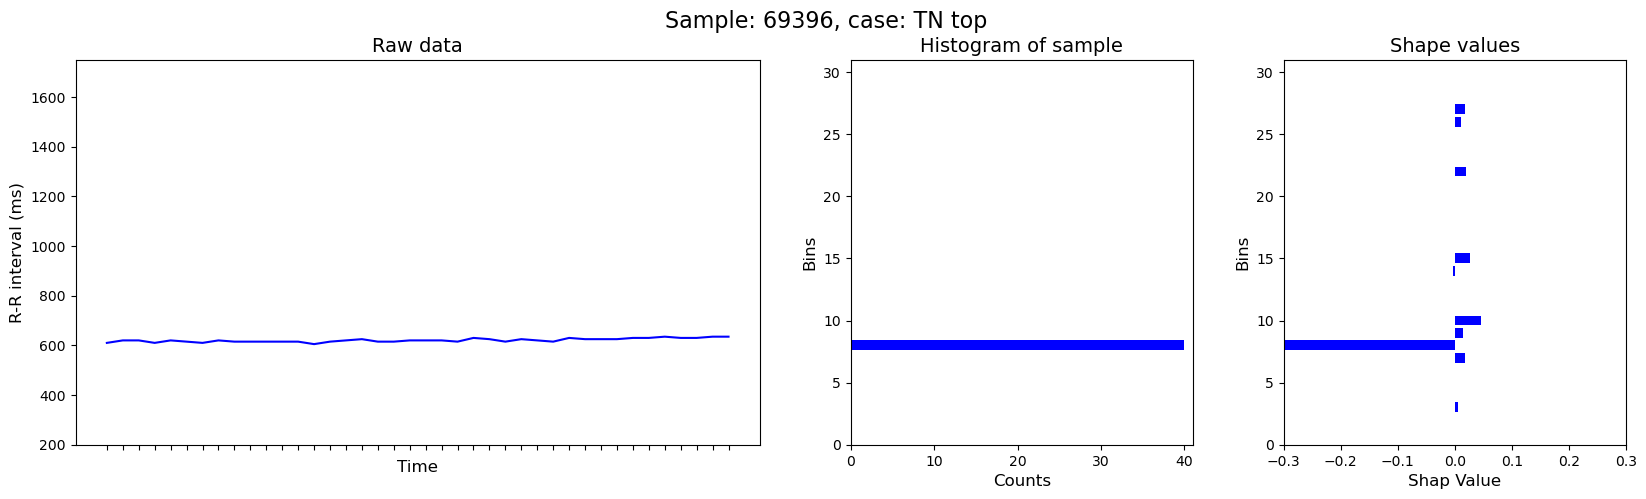

In [179]:
vis_SHAP_values(shap_val_top_tn,data_bin_top_tn,data_raw_top_tn,str(sampleID_top_tn), "TN top",color_case='blue')

In [182]:
# Plot top fn
file_scaled = 'samples/fn_sample_top_bin_scaled.csv'
file_raw = 'samples/fn_sample_top_raw.csv'
file_bin = 'samples/fn_sample_top_bin.csv'

data_top_fn= pd.read_csv(file_scaled).iloc[0]
data_raw_top_fn= pd.read_csv(file_raw)
sampleID_top_fn= data_raw_top_fn['Sample_id'].iloc[0]
data_raw_top_fn=data_raw_top_fn.iloc[0][:-1]
data_bin_top_fn = pd.read_csv(file_bin)
data_bin_top_fn = data_bin_top_fn[bin_column_names].iloc[0]
# shap_val_top_fn = get_shap_value(data_top_fn)

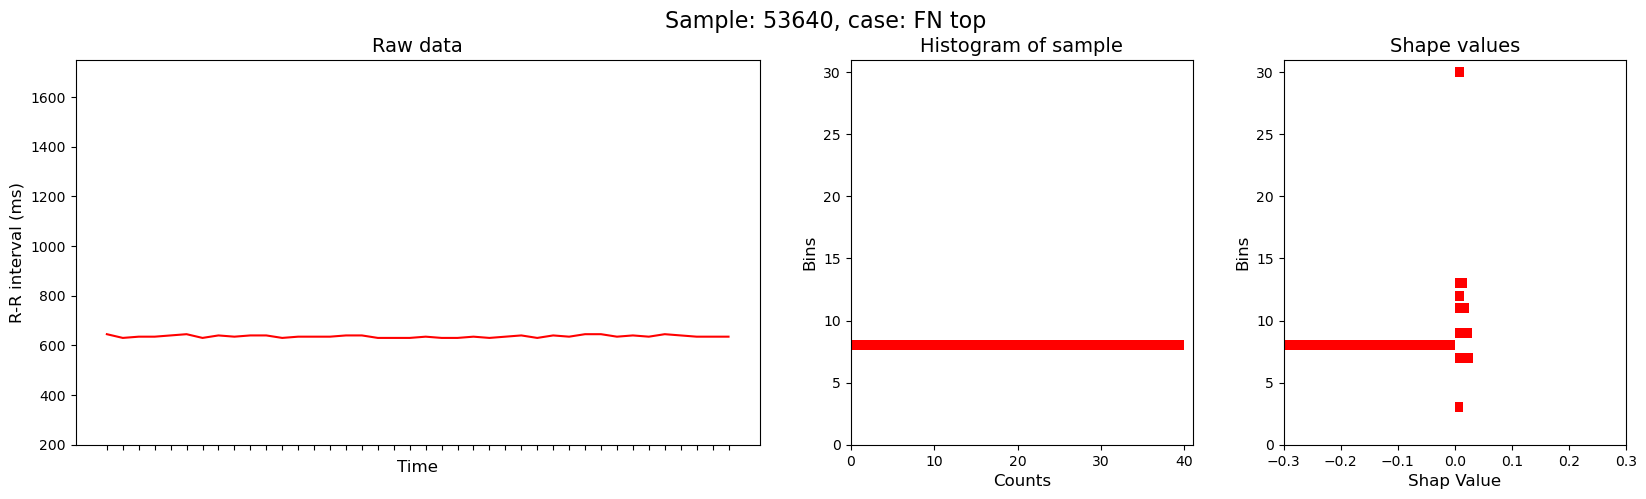

In [183]:
vis_SHAP_values(shap_val_top_fn,data_bin_top_fn,data_raw_top_fn,str(sampleID_top_fn), "FN top",color_case='red')

In [191]:
# Plot rightmiddle tn
file_scaled = 'samples/tp_sample_rightmiddle_bin_scaled.csv'
file_raw = 'samples/tp_sample_rightmiddle_raw.csv'
file_bin = 'samples/tp_sample_rightmiddle_bin.csv'

data_rightmiddle_tp= pd.read_csv(file_scaled).iloc[0]
data_raw_rightmiddle_tp= pd.read_csv(file_raw)
sampleID_rightmiddle_tp= data_raw_rightmiddle_tp['Sample_id'].iloc[0]
data_raw_rightmiddle_tp=data_raw_rightmiddle_tp.iloc[0][:-1]
data_bin_rightmiddle_tp = pd.read_csv(file_bin)
data_bin_rightmiddle_tp = data_bin_rightmiddle_tp[bin_column_names].iloc[0]
shap_val_rightmiddle_tp = get_shap_value(data_rightmiddle_tp)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.340e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.170e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:679: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=1.164e-02, previous alpha=1.13

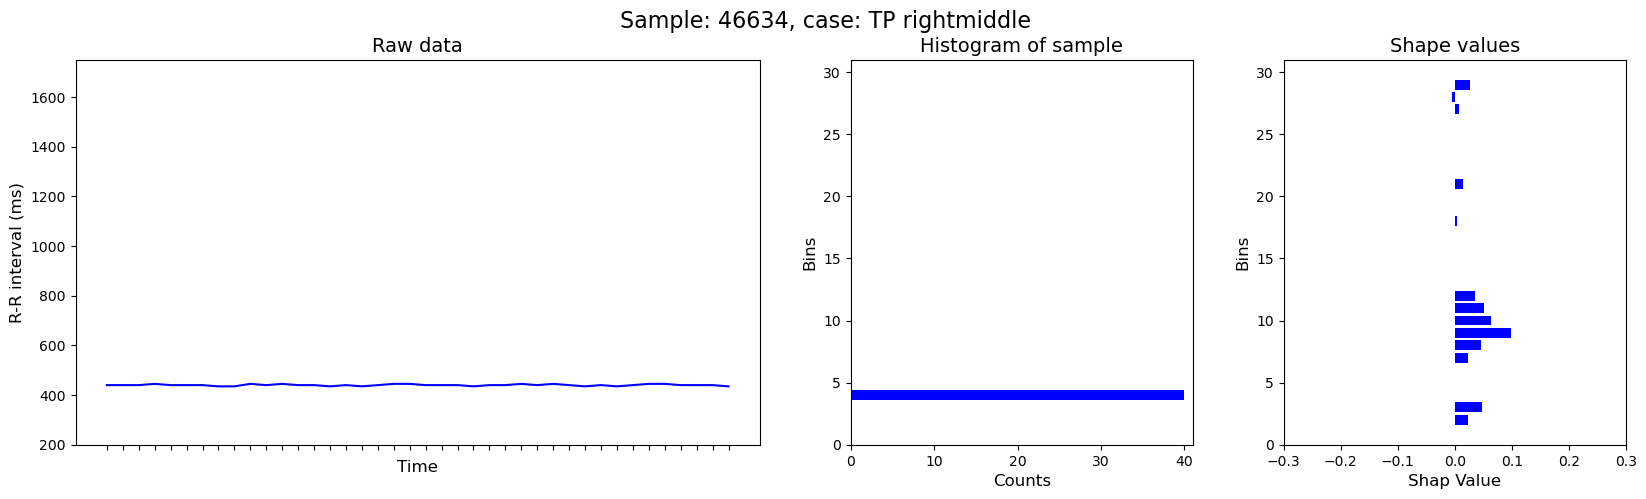

In [195]:
vis_SHAP_values(shap_val_rightmiddle_tp,data_bin_rightmiddle_tp,data_raw_rightmiddle_tp,str(sampleID_rightmiddle_tp), "TP rightmiddle",color_case='blue')

In [193]:
# Plot rightmiddle fp
file_scaled = 'samples/fp_sample_rightmiddle_bin_scaled.csv'
file_raw = 'samples/fp_sample_rightmiddle_raw.csv'
file_bin = 'samples/fp_sample_rightmiddle_bin.csv'

data_rightmiddle_fp= pd.read_csv(file_scaled).iloc[0]
data_raw_rightmiddle_fp= pd.read_csv(file_raw)
sampleID_rightmiddle_fp= data_raw_rightmiddle_fp['Sample_id'].iloc[0]
data_raw_rightmiddle_fp=data_raw_rightmiddle_fp.iloc[0][:-1]
data_bin_rightmiddle_fp = pd.read_csv(file_bin)
data_bin_rightmiddle_fp = data_bin_rightmiddle_fp[bin_column_names].iloc[0]
shap_val_rightmiddle_fp = get_shap_value(data_rightmiddle_fp)


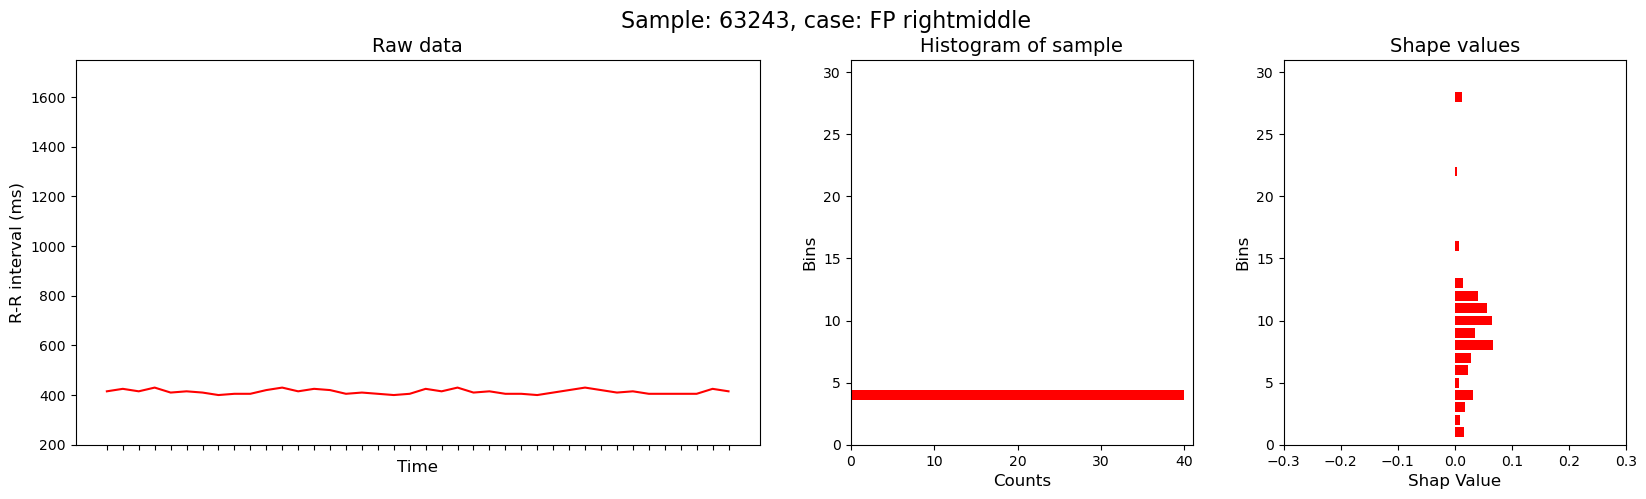

In [194]:
vis_SHAP_values(shap_val_rightmiddle_fp,data_bin_rightmiddle_fp,data_raw_rightmiddle_fp,str(sampleID_rightmiddle_fp), "FP rightmiddle",color_case='red')